In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
pd.set_option('display.max_columns', None)
from shapely.geometry import Point
import fiona
import math
import plotly.express as px
from thefuzz import fuzz
from thefuzz import process

/opt/tljh/user/lib/python3.9/site-packages/thefuzz/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
stores_2022 = pd.read_csv('/srv/data/my_shared_data_folder/rafi/2022_Business_Academic_QCQ_grocery.csv')
stores_2022.drop(['Unnamed: 0'],inplace=True,axis=1)
territories = ['PR', 'FM', 'MP', 'GU', 'VI', 'MH']
stores_2022 = stores_2022.drop(stores_2022[stores_2022['STATE'].isin(territories)].index)

In [5]:
#Filter Grocery stores by sic (starting with 5411)
grocery_sic = stores_2022.loc[stores_2022[['PRIMARY SIC CODE', 'SIC CODE', 'SIC CODE 1', 'SIC CODE 2', 'SIC CODE 3', 'SIC CODE 4']].astype(str).apply(lambda x: x.str.startswith('5411')).any(axis=1)]
grocery_sic.head()

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE
0,GOMART,55 POSTAL PLZ,MORGANTOWN,WV,26508,7005.0,61.0,304,2,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,554110.0,ALTERNATIVE FUELS,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,13.0,2482.0,2,NaN,NaN,NaN,NaN,998372387,NaN,124929449.0,50.0,389500.0,E,I,998372387.0,NaN,7,11000.0,3.0,39.594376,-79.954437,P,34060.0,2.0,390.0,54061.0
1,7-ELEVEN,485 E MAIN ST,EL CENTRO,CA,92243,2619.0,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,W,NaN,NaN,NaN,495660326,NaN,5863311.0,800.0,1272634.0,H,K,495660326.0,NaN,7,11400.0,3.0,32.792679,-115.536058,0,20940.0,2.0,0.0,6025.0
2,EL SOL MARKET,110 W MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1061.0,9,NaN,NaN,NaN,NaN,519605455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0
3,COOL SPRINGS GROCERY,241 WILDWOOD ST,MORGANTOWN,WV,26505,3141.0,61.0,304,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,2.0,382.0,9,NaN,NaN,NaN,NaN,817953730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,10400.0,4.0,39.652885,-79.986398,P,34060.0,2.0,390.0,54061.0
4,CIRCLE K,123 E MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,F,NaN,NaN,NaN,855113817,NaN,450720289.0,650.0,4981020.0,H,J,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0


In [6]:
grocery_t10_22 = grocery_sic.groupby('PARENT NUMBER', dropna=False).size().reset_index(name='COUNT')
grocery_t10_22.sort_values('COUNT', ascending=False, inplace=True)
grocery_t10_22.reset_index(drop=True,inplace=True)

# Create other row
other_row = grocery_t10_22.iloc[11:]
other_column = other_row['COUNT'].sum()

# Remove other rows
grocery_t10_22 = grocery_t10_22.iloc[:11]
grocery_t10_22.loc[len(grocery_t10_22)] = ["Other", other_column]

#grocery_t10_22.reset_index(drop=True, inplace=True)  # Reset index to start from 0

grocery_t10_22['PARENT NUMBER'] = grocery_t10_22['PARENT NUMBER'].astype(str)
grocery_t10_22['Percent'] = grocery_t10_22['COUNT'] / len(grocery_sic) * 100

grocery_t10_22.head()


,PARENT NUMBER,COUNT,Percent
0,nan,77818,49.287773
1,5863311.0,11939,7.561833
2,450720289.0,6814,4.315799
3,5889993.0,4397,2.784938
4,7521503.0,3574,2.263673


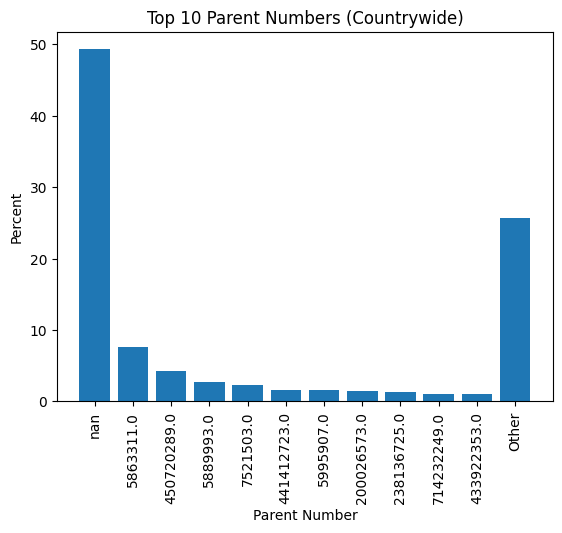

In [7]:
#Top 10 Parent (Country)
plt.bar(grocery_t10_22['PARENT NUMBER'], grocery_t10_22['Percent'])
plt.xlabel('Parent Number')
plt.ylabel('Percent')
plt.title('Top 10 Parent Numbers (Countrywide)')
plt.xticks(rotation=90)
plt.show()

In [8]:
grocery_sic['GEOMETRY'] = [Point(xy) for xy in zip(grocery_sic.LONGITUDE, grocery_sic.LATITUDE)]
grocery22_gdf = gpd.GeoDataFrame(grocery_sic, geometry='GEOMETRY')
grocery22_gdf.set_crs('epsg:4326', inplace=True)  

/tmp/ipykernel_785128/140022936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grocery_sic['GEOMETRY'] = [Point(xy) for xy in zip(grocery_sic.LONGITUDE, grocery_sic.LATITUDE)]


,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE,GEOMETRY
0,GOMART,55 POSTAL PLZ,MORGANTOWN,WV,26508,7005.0,61.0,304,2,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,554110.0,ALTERNATIVE FUELS,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,13.0,2482.0,2,NaN,NaN,NaN,NaN,998372387,NaN,124929449.0,50.0,389500.0,E,I,998372387.0,NaN,7,11000.0,3.0,39.594376,-79.954437,P,34060.0,2.0,390.0,54061.0,POINT (-79.95444 39.59438)
1,7-ELEVEN,485 E MAIN ST,EL CENTRO,CA,92243,2619.0,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,W,NaN,NaN,NaN,495660326,NaN,5863311.0,800.0,1272634.0,H,K,495660326.0,NaN,7,11400.0,3.0,32.792679,-115.536058,0,20940.0,2.0,0.0,6025.0,POINT (-115.53606 32.79268)
2,EL SOL MARKET,110 W MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1061.0,9,NaN,NaN,NaN,NaN,519605455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0,POINT (-115.58180 33.05180)
3,COOL SPRINGS GROCERY,241 WILDWOOD ST,MORGANTOWN,WV,26505,3141.0,61.0,304,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,2.0,382.0,9,NaN,NaN,NaN,NaN,817953730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,10400.0,4.0,39.652885,-79.986398,P,34060.0,2.0,390.0,54061.0,POINT (-79.98640 39.65288)
4,CIRCLE K,123 E MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,F,NaN,NaN,NaN,855113817,NaN,450720289.0,650.0,4981020.0,H,J,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0,POINT (-115.58180 33.05180)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203497,T-MART,103 SUNRISE DR,SUNRISE BEACH,TX,78643,9287.0,299.0,325,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,343201.0,PLUMBING FIXTURES & SUPPLIES-MFRS,572222.0,PUMPS-RETAIL,508444.0,PUMPS (WHLS),525104.0,HARDWARE-RETAIL,594131.0,FISHING TACKLE-DEALERS,2022,NaN,2.0,441.0,9,NaN,NaN,NaN,NaN,880617683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,970300.0,1.0,30.593381,-98.425843,P,0.0,NaN,0.0,48299.0,POINT (-98.42584 30.59338)
203498,H-E-B,1434 W WELLS BRANCH PKWY,PFLUGERVILLE,TX,78660,3153.0,453.0,512,2,G,H,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,554101.0,SERVICE STATIONS-GASOLINE & OIL,729954.0,VEHICLE & DRIVERS LICENSING SERVICES,581208.0,RESTAURANTS,NaN,NaN,NaN,NaN,2022,39106.0,270.0,71857.0,2,F,NaN,NaN,NaN,403451198,NaN,436443592.0,1000.0,23000000.0,I,K,403451198.0,NaN,8,1840.0,3.0,30.442331,-97.664580,P,12420.0,2.0,0.0,48453.0,POINT (-97.66458 30.44233)
203500,SAC N PAC,2101 N STATE HIGHWAY 123,SAN MA

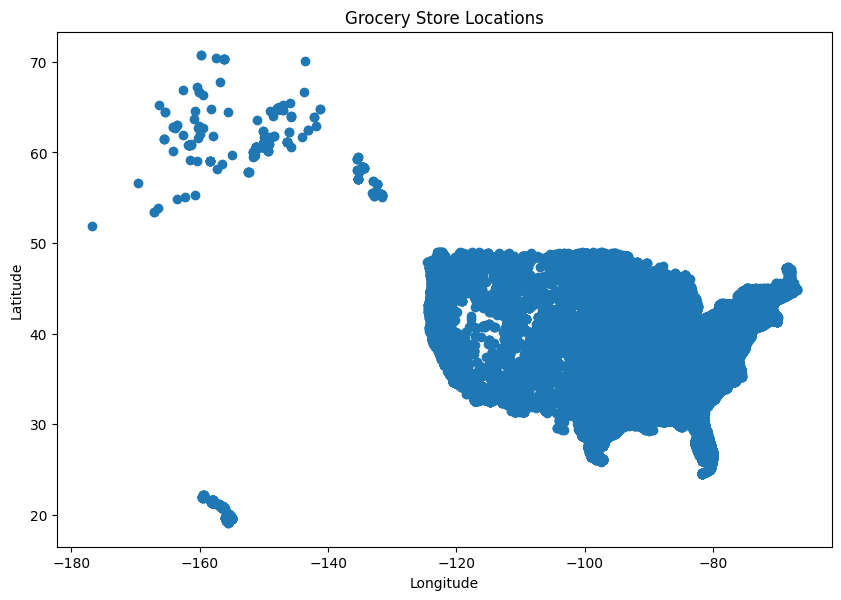

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

grocery22_gdf.plot(ax=ax)
ax.set_title('Grocery Store Locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


In [10]:
grocery22_gdf["TOP TEN"] = grocery22_gdf['PARENT NUMBER'].apply(lambda x: '5863311.0' in str(x) or '450720289.0' in str(x) or '5889993.0' in str(x)or '7521503.0' in str(x)or '441412723.0' in str(x) or '5995907.0' in str(x) or '200026573.0' in str(x)or '238136725.0' in str(x)or '714232249.0' in str(x) or '433922353.0' in str(x))


In [11]:
grocery22_gdf.loc[:, "INDEPENDENT STORE"] = False
grocery22_gdf.loc[(grocery_sic['PARENT NUMBER'].isna()), 'INDEPENDENT STORE'] = True
grocery22_gdf.head()

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE,GEOMETRY,TOP TEN,INDEPENDENT STORE
0,GOMART,55 POSTAL PLZ,MORGANTOWN,WV,26508,7005.0,61.0,304,2,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,554110.0,ALTERNATIVE FUELS,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,13.0,2482.0,2,NaN,NaN,NaN,NaN,998372387,NaN,124929449.0,50.0,389500.0,E,I,998372387.0,NaN,7,11000.0,3.0,39.594376,-79.954437,P,34060.0,2.0,390.0,54061.0,POINT (-79.95444 39.59438),False,False
1,7-ELEVEN,485 E MAIN ST,EL CENTRO,CA,92243,2619.0,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,W,NaN,NaN,NaN,495660326,NaN,5863311.0,800.0,1272634.0,H,K,495660326.0,NaN,7,11400.0,3.0,32.792679,-115.536058,0,20940.0,2.0,0.0,6025.0,POINT (-115.53606 32.79268),True,False
2,EL SOL MARKET,110 W MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1061.0,9,NaN,NaN,NaN,NaN,519605455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0,POINT (-115.58180 33.05180),False,True
3,COOL SPRINGS GROCERY,241 WILDWOOD ST,MORGANTOWN,WV,26505,3141.0,61.0,304,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,2.0,382.0,9,NaN,NaN,NaN,NaN,817953730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,10400.0,4.0,39.652885,-79.986398,P,34060.0,2.0,390.0,54061.0,POINT (-79.98640 39.65288),False,True
4,CIRCLE K,123 E MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,F,NaN,NaN,NaN,855113817,NaN,450720289.0,650.0,4981020.0,H,J,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0,POINT (-115.58180 33.05180),True,False


In [12]:
grocery22_gdf.drop(["TOP TEN","INDEPENDENT STORE"],inplace=True,axis=1)

In [13]:
def store_type(row):
    '''Based on the country T10 parent number's assigns each company to the group TOP TEN, INDEPENDENT STORE, or OTHER'''
    top_ten = [5863311.0, 450720289.0, 5889993.0, 7521503.0, 441412723.0, 5995907.0, 200026573.0, 238136725.0, 714232249.0, 433922353.0]
    
    parent_num = row['PARENT NUMBER']  
    
    if parent_num in top_ten:
        return 'TOP TEN'
    if math.isnan(parent_num):
        return 'INDEPENDENT STORE'
    
    return 'OTHER'

grocery22_gdf['STORE TYPE'] = grocery22_gdf.apply(store_type, axis=1)
grocery22_gdf.head()

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE,GEOMETRY,STORE TYPE
0,GOMART,55 POSTAL PLZ,MORGANTOWN,WV,26508,7005.0,61.0,304,2,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,554110.0,ALTERNATIVE FUELS,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,13.0,2482.0,2,NaN,NaN,NaN,NaN,998372387,NaN,124929449.0,50.0,389500.0,E,I,998372387.0,NaN,7,11000.0,3.0,39.594376,-79.954437,P,34060.0,2.0,390.0,54061.0,POINT (-79.95444 39.59438),OTHER
1,7-ELEVEN,485 E MAIN ST,EL CENTRO,CA,92243,2619.0,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,W,NaN,NaN,NaN,495660326,NaN,5863311.0,800.0,1272634.0,H,K,495660326.0,NaN,7,11400.0,3.0,32.792679,-115.536058,0,20940.0,2.0,0.0,6025.0,POINT (-115.53606 32.79268),TOP TEN
2,EL SOL MARKET,110 W MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1061.0,9,NaN,NaN,NaN,NaN,519605455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0,POINT (-115.58180 33.05180),INDEPENDENT STORE
3,COOL SPRINGS GROCERY,241 WILDWOOD ST,MORGANTOWN,WV,26505,3141.0,61.0,304,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,2.0,382.0,9,NaN,NaN,NaN,NaN,817953730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,10400.0,4.0,39.652885,-79.986398,P,34060.0,2.0,390.0,54061.0,POINT (-79.98640 39.65288),INDEPENDENT STORE
4,CIRCLE K,123 E MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,F,NaN,NaN,NaN,855113817,NaN,450720289.0,650.0,4981020.0,H,J,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0,POINT (-115.58180 33.05180),TOP TEN


In [14]:
store_type = grocery22_gdf.groupby("STORE TYPE").count()[["COMPANY"]].reset_index().rename(columns={"COMPANY": "COUNT"})
store_type.head()

,STORE TYPE,COUNT
0,INDEPENDENT STORE,77810
1,OTHER,40514
2,TOP TEN,39553


In [16]:
grocery22_gdf[grocery22_gdf['COMPANY'].isna()] #8 companies with no name (option would be to drop those rows)

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE,GEOMETRY,STORE TYPE
24442,NaN,20207 MCKENNEY HWY,STONY CREEK,VA,23882,2229.0,53.0,804,1,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,15.0,2301.0,9,NaN,NaN,NaN,NaN,436873257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,840100.0,1.0,36.945282,-77.555286,P,40060.0,2.0,0.0,51053.0,POINT (-77.55529 36.94528),INDEPENDENT STORE
92875,NaN,1719 KENWOOD DR,SAN ANGELO,TX,76903,8340.0,451.0,325,1,A,B,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,4.0,920.0,9,NaN,NaN,NaN,NaN,735520631,NaN,NaN,NaN,NaN,NaN,NaN,740644536.0,NaN,7,1000.0,3.0,31.443151,-100.446388,P,41660.0,2.0,0.0,48451.0,POINT (-100.44639 31.44315),INDEPENDENT STORE
116742,NaN,1088 N MOONEY BLVD,TULARE,CA,93274,2417.0,107.0,559,1,A,B,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,3.0,800.0,9,NaN,NaN,NaN,NaN,436340738,NaN,NaN,NaN,NaN,NaN,NaN,706173656.0,NaN,8,2400.0,4.0,36.225627,-119.312385,P,47300.0,2.0,0.0,6107.0,POINT (-119.31239 36.22563),INDEPENDENT STORE
117185,NaN,1309 E MORGAN ST,MARTINSVILLE,IN,46151,1728.0,109.0,765,1,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,7.0,1506.0,9,NaN,NaN,NaN,NaN,711091320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,510800.0,1.0,39.427550,-86.412768,P,26900.0,2.0,294.0,18109.0,POINT (-86.41277 39.42755),INDEPENDENT STORE
142220,NaN,8111 86TH AVE NW,GIG HARBOR,WA,98332,6712.0,53.0,253,1,A,B,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,3.0,869.0,9,NaN,NaN,NaN,NaN,437012791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,72504.0,2.0,47.330921,-122.652858,P,42660.0,2.0,500.0,53053.0,POINT (-122.65286 47.33092),INDEPENDENT STORE
169193,NaN,3220 MAIN ST,BARNSTABLE,MA,2630,1107.0,1.0,774,1,C,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,10.0,2449.0,9,NaN,NaN,NaN,NaN,439961064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,12200.0,2.0,41.701838,-70.303043,P,12700.0,2.0,148.0,25001.0,POINT (-70.30304 41.70184),INDEPENDENT STORE
174966,NaN,2613 BARRACKS RD,CHARLOTTESVILLE,VA,22901,2120.0,3.0,434,1,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1240.0,9,NaN,NaN,NaN,NaN,438184803,NaN,NaN,NaN,NaN,NaN,NaN,588758961.0,NaN,7,10800.0,4.0,38.062967,-78.512013,P,16820.0,2.0,0.0,51003.0,POINT (-78.51201 38.06297),INDEPENDENT STORE
187145,NaN,610 MACON ST,MCDONOUGH,GA,30253,3532.0,151.0,770,1,A,B,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,3.0,622.0,9,NaN,NaN,NaN,NaN,428062648,NaN,NaN,NaN,NaN,NaN,NaN,712006695.0,NaN,7,70304.0,2.0,33.431323,-84.144972,P,12060.0,2.0,122.0,13151.0,POINT (-84.14497 33.43132),INDEPENDENT STORE


In [17]:
#Subsects IL
il = grocery22_gdf.loc[grocery22_gdf["STATE"] == 'IL', :]
il = il.drop(["GEOMETRY","STORE TYPE"],axis=1)

def store_type(row):
    '''Based on the country T10 parent number's assigns each company to the group TOP TEN, INDEPENDENT STORE, or OTHER'''
    top_ten_il = [441412723.0, 5863311.0, 450720289.0, 200026573.0, 5995907.0, 5889993.0, 7521503.0, 1490291.0, 723360636.0, 5644232.0]
    
    parent_num = row['PARENT NUMBER']  
    
    if parent_num in top_ten_il:
        return 'TOP TEN (IL)'
    if math.isnan(parent_num):
        return 'INDEPENDENT STORE (IL)'
    
    return 'OTHER (IL)'
il['STORE TYPE'] = il.apply(store_type, axis=1)
il.head()

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE,STORE TYPE
13,KROGER,301 E MCKINLEY RD,OTTAWA,IL,61350,4805.0,99.0,815,2,E,F,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,70.0,14158.0,2,P,NaN,NaN,NaN,152123287,NaN,7521503.0,1200.0,137888000.0,I,I,152123287.0,NaN,7,963500.0,1.0,41.323858,-88.836271,P,36837.0,1.0,176.0,17099.0,TOP TEN (IL)
86,CIRCLE K,290 MAIN ST,MARSEILLES,IL,61341,NaN,99.0,815,2,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,554110.0,ALTERNATIVE FUELS,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,11.0,2225.0,2,F,NaN,NaN,NaN,312709629,NaN,450720289.0,650.0,4981020.0,H,J,NaN,NaN,5,962400.0,2.0,41.333000,-88.701000,X,36837.0,1.0,176.0,17099.0,TOP TEN (IL)
199,SPRING VALLEY SUPERMARKET,117 S SPALDING ST,SPRING VALLEY,IL,61362,2097.0,11.0,815,2,E,E,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,542107.0,MEAT-RETAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,60.0,8908.0,9,NaN,NaN,NaN,NaN,2994101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,965200.0,2.0,41.323951,-89.199282,P,36837.0,1.0,176.0,17011.0,INDEPENDENT STORE (IL)
238,FREEDOM OIL CO,402 N MAIN ST,TOLUCA,IL,61369,9025.0,123.0,815,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,7.0,1545.0,2,NaN,NaN,NaN,NaN,308353358,NaN,452637325.0,17.0,52200.0,C,H,NaN,NaN,3,961500.0,2.0,41.005092,-89.133807,P,37900.0,2.0,0.0,17123.0,OTHER (IL)
316,SENECA FOOD MART,271 S MAIN ST,SENECA,IL,61360,9415.0,99.0,815,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,209903.0,FOOD PRODUCTS & MANUFACTURERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,8.0,1618.0,2,NaN,NaN,NaN,NaN,152142808,NaN,558247.0,75.0,1385280.0,E,K,NaN,NaN,4,963700.0,1.0,41.306622,-88.610207,P,36837.0,1.0,176.0,17099.0,OTHER (IL)


In [18]:
groc_il = il.groupby('PARENT NUMBER', dropna=False).count().reset_index()[['PARENT NUMBER','COMPANY']]
groc_il.sort_values('COMPANY', ascending=False, inplace=True)
groc_il.reset_index(drop=True,inplace=True)

groc_tp10_il = groc_il.iloc[:11]
other_groc = groc_il['COMPANY'].sum() - groc_tp10_il['COMPANY'].sum()

groc_tp10_il.loc[len(groc_tp10_il.index)] = ["Other", other_groc]
groc_tp10_il['PARENT NUMBER'] = groc_tp10_il['PARENT NUMBER'].astype(str)
groc_tp10_il.loc[:, 'Percent'] = groc_tp10_il.loc[:, 'COMPANY'] / len(il) * 100
groc_tp10_il.rename(columns={"COMPANY":"COUNT"})

/tmp/ipykernel_785128/2855846445.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groc_tp10_il.loc[len(groc_tp10_il.index)] = ["Other", other_groc]
/tmp/ipykernel_785128/2855846445.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groc_tp10_il['PARENT NUMBER'] = groc_tp10_il['PARENT NUMBER'].astype(str)
/tmp/ipykernel_785128/2855846445.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,PARENT NUMBER,COUNT,Percent
0,nan,2236,43.074552
1,441412723.0,525,10.113658
2,5863311.0,446,8.591793
3,450720289.0,329,6.337893
4,200026573.0,221,4.257369
5,5995907.0,189,3.640917
6,5889993.0,134,2.581391
7,7521503.0,122,2.350222
8,1490291.0,89,1.714506
9,723360636.0,68,1.309960


In [19]:
#FINDS IL top ten grocery stores. 
groc_il = il.groupby('PARENT NUMBER', dropna=False).agg({'EMPLOYEE SIZE (5) - LOCATION': 'sum',
                                                        'STORE TYPE': 'first'}).reset_index()
groc_il.sort_values('EMPLOYEE SIZE (5) - LOCATION', ascending=False, inplace=True)
groc_il.reset_index()
groc_il.head()

,PARENT NUMBER,EMPLOYEE SIZE (5) - LOCATION,STORE TYPE
7,5995907.0,34245.0,TOP TEN (IL)
78,NaN,17766.0,INDEPENDENT STORE (IL)
8,7521503.0,11193.0,TOP TEN (IL)
4,5644232.0,8702.0,TOP TEN (IL)
39,441412723.0,6156.0,TOP TEN (IL)


### CLEANING

In [98]:
country_independent = grocery22_gdf.loc[grocery22_gdf["STORE TYPE"] == "INDEPENDENT STORE", :]
country_independent_sorted = country_independent.sort_values(by=['EMPLOYEE SIZE (5) - LOCATION'], ascending=False)
country_independent50 = country_independent_sorted.iloc[:50, :]
country_independent50.head()
#top 10 parent compnaies in the country 
# 1) 5863311.0 = parent company = Seven & I holdings 
# 2) 450720289.0 = parent company(s) = Alimentation Couche-Tard, Convenience Retail Asia
# 3) 5889993.0 = parent company = Walmart 
# 4) 7521503.0 = parent company = Kroger 
#5) 441412723.0 = parent company(s)= Rutters Holding Inc, CHR Corporation 
#6) 5995907.0 = parent company = Albertson, American stores 3
#7) 200026573.0 = parent company = Albrecht Discounts(aldi)
#8) not showing data Ahold Delhaize
#9) 714232249.0 = parentt company = Clark Enterprises Inc
#10) 433922353.0 = parent compnay = Murphy Oil Corporation USA 

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE,GEOMETRY,STORE TYPE
141700,LA RAZA MARKET,705 23RD ST,RICHMOND,CA,94804,1446.0,13.0,510,2,I,J,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,2000.0,568730.0,9,NaN,NaN,NaN,NaN,928137330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,375000.0,1.0,37.942235,-122.347799,P,41860.0,2.0,488.0,6013.0,POINT (-122.34780 37.94223),INDEPENDENT STORE
43408,AFFILIATEDFOODS INC,1401 W FARMERS AVE,AMARILLO,TX,79118,6134.0,381.0,806,2,I,I,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,514105.0,GROCERS-WHOLESALE,514801.0,FRUITS & VEGETABLES-WHOLESALE,514704.0,MEAT-WHOLESALE,514961.0,DISTRIBUTOR-GROCERIES (WHLS),514101.0,FOOD PRODUCTS (WHLS),2022,39106.0,2000.0,466925.0,9,NaN,1945.0,NaN,NaN,668815426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,22002.0,1.0,35.133996,-101.850992,P,11100.0,2.0,108.0,48381.0,POINT (-101.85099 35.13400),INDEPENDENT STORE
4854,GENUARDI'S FAMILY MARKET LP,20427 N 27TH AVE # 4501,PHOENIX,AZ,85027,3241.0,13.0,623,2,I,I,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,1500.0,343523.0,9,NaN,NaN,NaN,NaN,414622376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,614600.0,5.0,33.673002,-112.115248,P,38060.0,2.0,429.0,4013.0,POINT (-112.11525 33.67300),INDEPENDENT STORE
40083,SSP PARTNERS,708 N US HIGHWAY 77,SCHULENBURG,TX,78956,5638.0,149.0,979,2,H,I,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,600.0,100839.0,9,NaN,NaN,NaN,NaN,695103747,NaN,NaN,NaN,NaN,NaN,NaN,695103747.0,NaN,5,970600.0,3.0,29.694457,-96.903156,P,0.0,NaN,0.0,48149.0,POINT (-96.90316 29.69446),INDEPENDENT STORE
170019,ZABAR'S GOURMET CATERING,2245 BROADWAY,NEW YORK,NY,10024,5899.0,61.0,212,2,H,G,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,581212.0,CATERERS,571929.0,HOUSEWARES-RETAIL,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,500.0,41255.0,9,NaN,1934.0,NaN,NaN,414520044,NaN,NaN,NaN,NaN,NaN,NaN,414520044.0,NaN,8,16700.0,3.0,40.784844,-73.979446,P,35620.0,2.0,408.0,36061.0,POINT (-73.97945 40.78484),INDEPENDENT STORE


In [89]:
top50 = country_independent50[["COMPANY"]]
top50.duplicated()
top50.iloc[20]
top50.loc[top50.COMPANY=="EL SOL MARKET"]

,COMPANY
2,EL SOL MARKET
76,EL SOL MARKET


In [96]:
top50 = country_independent50["COMPANY"]
process.extract("citgo", top50, limit=10)
#citgo
#el sol (3)


[('CITGO CONVENIENT FOOD MART', 90, 11),
 ('VDC GROUP INC', 54, 91),
 ('GUILFORD FOOD STOP LLC', 51, 54),
 ('GWIT', 44, 80),
 ('DURAND GROCERY & QUALITY MEAT', 38, 67),
 ('COOL SPRINGS GROCERY', 36, 3),
 ('LIGHT & SIREN', 36, 34),
 ('MILFORKQUIKMART', 36, 35),
 ('CALIFORNIA SUPER MARKET', 36, 40),
 ('CORNER STORE-NEW HAVEN', 36, 64)]

In [94]:
top50 = country_independent50["COMPANY"]
input_list = [
    "Baker’s",
    "City Market",
    "Dillons",
    "Food 4 Less",
    "Foods Co",
    "Fred Meyer",
    "Fry’s",
    "Gerbes",
    "Jay C Food Store",
    "King Soopers",
    "Kroger",
    "Mariano’s",
    "Metro Market",
    "Pay-Less Super Markets",
    "Pick’n Save",
    "QFC",
    "Ralphs",
    "Ruler",
    "Smith’s Food and Drug"
]

matches = []

for item in input_list:
    match = process.extractOne(item, top50)
    if match:
        matches.append(match[0])

print(matches)


["DANIEL'S MARKET", 'MARKET', "GRILLO'S MARKET", 'CITGO CONVENIENT FOOD MART', 'SUPER ONE FOODS', 'FRIENDLY MARKET FRANKFORT', "DANIEL'S MARKET", 'FAMILY EXPRESS', 'CITGO CONVENIENT FOOD MART', 'COOL SPRINGS GROCERY', 'COOL SPRINGS GROCERY', "MR T'S", 'MARKET', 'MARKET', "SEVEN'S", 'COOL SPRINGS GROCERY', 'PROPST JIM GROCERY', 'COOL SPRINGS GROCERY', "MR T'S"]


### PLOTLY MAPPING

In [ ]:
import plotly.express as px

# Create a scattermapbox plot
fig = px.scatter_mapbox(grocery22_gdf, lat="LATITUDE", lon="LONGITUDE", hover_data=["COMPANY"], color="STORE TYPE", color_discrete_sequence=["blue", "green", "red"], mapbox_style="open-street-map")

fig.show()

In [102]:
grocery22_gdf.head()

,company,address line 1,city,state,zipcode,zip4,county code,area code,idcode,location employee size code,location sales volume code,primary sic code,sic6_descriptions,primary naics code,naics8 descriptions,sic code,sic6_descriptions (sic),sic code 1,sic6_descriptions (sic1),sic code 2,sic6_descriptions(sic2),sic code 3,sic6_descriptions(sic3),sic code 4,sic6_descriptions(sic4),archive version year,yellow page code,employee size (5) - location,sales volume (9) - location,business status code,industry specific first byte,year established,office size code,company holding status,abi,subsidiary number,parent number,parent actual employee size,parent actual sales volume,parent employee size code,parent sales volume code,site number,address type indicator,population code,census tract,census block,latitude,longitude,match code,cbsa code,cbsa level,csa code,fips code,geometry,store type
0,GOMART,55 POSTAL PLZ,MORGANTOWN,WV,26508,7005.0,61.0,304,2,C,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,554110.0,ALTERNATIVE FUELS,NaN,NaN,NaN,NaN,NaN,NaN,2022,21303.0,13.0,2482.0,2,NaN,NaN,NaN,NaN,998372387,NaN,124929449.0,50.0,389500.0,E,I,998372387.0,NaN,7,11000.0,3.0,39.594376,-79.954437,P,34060.0,2.0,390.0,54061.0,POINT (-79.95444 39.59438),OTHER
1,7-ELEVEN,485 E MAIN ST,EL CENTRO,CA,92243,2619.0,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,W,NaN,NaN,NaN,495660326,NaN,5863311.0,800.0,1272634.0,H,K,495660326.0,NaN,7,11400.0,3.0,32.792679,-115.536058,0,20940.0,2.0,0.0,6025.0,POINT (-115.53606 32.79268),TOP TEN
2,EL SOL MARKET,110 W MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,5.0,1061.0,9,NaN,NaN,NaN,NaN,519605455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0,POINT (-115.58180 33.05180),INDEPENDENT STORE
3,COOL SPRINGS GROCERY,241 WILDWOOD ST,MORGANTOWN,WV,26505,3141.0,61.0,304,2,A,A,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,2.0,382.0,9,NaN,NaN,NaN,NaN,817953730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,10400.0,4.0,39.652885,-79.986398,P,34060.0,2.0,390.0,54061.0,POINT (-79.98640 39.65288),INDEPENDENT STORE
4,CIRCLE K,123 E MAIN ST,WESTMORLAND,CA,92281,NaN,25.0,760,2,B,C,541103,CONVENIENCE STORES,44512001.0,CONVENIENCE STORES,554101.0,SERVICE STATIONS-GASOLINE & OIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,NaN,6.0,1273.0,2,F,NaN,NaN,NaN,855113817,NaN,450720289.0,650.0,4981020.0,H,J,NaN,NaN,3,10200.0,1.0,33.051800,-115.581800,X,20940.0,2.0,0.0,6025.0,POINT (-115.58180 33.05180),TOP TEN


In [104]:
parent_dict = {}
grocery22_gdf.columns = grocery22_gdf.columns.str.lower()

for index, row in grocery22_gdf.iterrows():
    parent_num = row['parent number']
    if parent_num in parent_dict.keys():
        parent_dict[parent_num].append(row["company"])
    else:
        parent_dict[parent_num] = [row["company"]]


In [109]:
most_common_per_parent = {}
for parent_num, companies in parent_dict.items():
    most_common = max(set(companies), key=companies.count)
    most_common_per_parent[parent_num] = most_common



KeyboardInterrupt: 

In [116]:
grocery22_gdf.columns = grocery22_gdf.columns.str.upper()
g2 = grocery22_gdf
g22=g2.replace({"PARENT NUMBER": most_common_per_parent})


In [129]:
g22 = g22.rename(columns={"PARENT NUMBER":"LARGEST STORE"})
#g22 = g22[["COMPANY", "LARGEST STORE"]]
#g22.head()
large = g22["LARGEST STORE"]
duplicates = large[large.duplicated()]
print(duplicates)


3          S & K COUNTRY STORE
5          S & K COUNTRY STORE
8                       KROGER
11         S & K COUNTRY STORE
13                      KROGER
                  ...         
203497     S & K COUNTRY STORE
203498                   H-E-B
203500                7-ELEVEN
203501    TOPS FRIENDLY MARKET
203502        CUMBERLAND FARMS
Name: LARGEST STORE, Length: 156855, dtype: object


In [143]:
parent_dict = {}
grocery22_gdf.columns = grocery22_gdf.columns.str.lower()

for index, row in grocery22_gdf.iterrows():
    parent_num = row['parent number']
    parent_dict[parent_num] = parent_dict.get(parent_num, [])
    parent_dict[parent_num].append(row["company"])


In [145]:
most_common_per_parent = {}
for parent_num, companies in parent_dict.items():
    most_common = max(set(companies), key=companies.count)
    most_common_per_parent[parent_num] = most_common

In [144]:
parent_dict

{124929449.0: ['GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART INC',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',
  'GOMART',

In [147]:
most_common_per_parent

{124929449.0: 'GOMART',
 5863311.0: '7-ELEVEN',
 nan: 'EL SOL MARKET',
 nan: 'COOL SPRINGS GROCERY',
 450720289.0: 'CIRCLE K',
 nan: 'EL SOL MEAT MARKET',
 1490291.0: 'AMPM',
 7521503.0: 'KROGER',
 5889993.0: 'WALMART GROCERY PICKUP',
 140507807.0: 'PAR MAR STORES',
 nan: 'CITGO CONVENIENT FOOD MART',
 834898306.0: 'WOODS SUPERMARKET',
 6829915.0: 'GIANT EAGLE',
 nan: 'SKY MARKET',
 723360636.0: 'E-Z MART',
 861921039.0: 'STATER BROS MARKETS',
 441482742.0: "KRAUSZER'S FOOD STORE",
 499344661.0: 'NATURAL GROCERS',
 nan: 'LIGHT & SIREN',
 nan: 'MILFORKQUIKMART',
 3456464.0: 'ENMARKET',
 nan: 'INDIA BAZAR',
 nan: 'CALIFORNIA SUPER MARKET',
 nan: 'MARKET SQUARE',
 nan: 'CASH SMART',
 441412723.0: "CASEY'S",
 979589546.0: 'HY-VEE',
 nan: 'FAST BREAK FOOD MART',
 nan: "MR T'S",
 nan: "DANIEL'S MARKET",
 nan: 'GUILFORD FOOD STOP LLC',
 nan: 'FOODMART',
 822125985.0: 'SPEEDYQ MARKETS',
 885216069.0: 'FOOD GIANT',
 nan: 'RIVERA GROCERY LLC',
 769874507.0: 'TOPS FRIENDLY MARKET',
 7539513.0: 'S

In [148]:
ini_dict = most_common_per_parent
 
# printing initial_dictionary
#print("initial_dictionary", str(ini_dict))
 
# finding duplicate values
# from dictionary
# using a naive approach
rev_dict = {}
 
for key, value in ini_dict.items():
    rev_dict.setdefault(value, set()).add(key)
     
result = [key for key, values in rev_dict.items()
                              if len(values) > 1]
 
# printing result
print("duplicate values", str(result))

duplicate values ['7-ELEVEN', 'EL SOL MARKET', 'CIRCLE K', 'AMPM', 'KROGER', 'WOODS SUPERMARKET', 'GIANT EAGLE', 'SKY MARKET', 'E-Z MART', 'INDIA BAZAR', 'CALIFORNIA SUPER MARKET', 'MARKET SQUARE', "CASEY'S", 'HY-VEE', 'FAST BREAK FOOD MART', "DANIEL'S MARKET", 'FOODMART', 'SPEEDYQ MARKETS', 'FOOD GIANT', 'TOPS FRIENDLY MARKET', 'SHOPRITE', 'CTOWN SUPERMARKETS', 'ASIA GROCERS', 'CUMBERLAND FARMS', 'MEIJER', 'GOLDEN MARKET', 'MARKET', 'CHECKERS FOOD STORE', 'XTRA MART', 'CENEX', 'SMART & FINAL EXTRA!', 'LITTLE GENERAL STORE', 'SUPER ONE FOODS', 'SHEETZ', 'FAMILY EXPRESS', "SHOP 'N SAVE", 'SAFEWAY', 'NEWTON MARKET', 'ATLANTIS FRESH MARKET', 'BUCHE FOODS', 'PUBLIX', 'AHOLD', "TRADER JOE'S", 'SAVE-A-LOT', 'BIG Y', 'J J MARKET', 'CHERRY MARKET', 'FOOD LION', 'VILLAGE MART', 'ONE STOP SHOPPE', 'FOOD MART', 'ALDI', 'DASH IN', 'U-SAVE FOOD STORE', 'S & G CONVENIENCE MART', 'KING MARKET', 'QUICK & EASY', 'SUBHLAXMI GROCERS', 'HARPS FOOD STORES', 'STINKER', 'GROCERY OUTLET', 'QUICK MART', 'KIRKW

In [153]:
desired_keys = []

vals = list(most_common_per_parent.values())

for key, value in most_common_per_parent.items():
   if vals.count(value) > 1:
        desired_keys.append(key)

In [154]:
desired_keys

[5863311.0,
 nan,
 450720289.0,
 1490291.0,
 7521503.0,
 834898306.0,
 6829915.0,
 nan,
 723360636.0,
 nan,
 nan,
 nan,
 441412723.0,
 979589546.0,
 nan,
 nan,
 nan,
 822125985.0,
 885216069.0,
 769874507.0,
 7539513.0,
 449490770.0,
 nan,
 714232249.0,
 nan,
 5644232.0,
 nan,
 nan,
 nan,
 387910128.0,
 850307737.0,
 425105750.0,
 453562282.0,
 nan,
 2984524.0,
 nan,
 434098849.0,
 5995907.0,
 nan,
 423248944.0,
 nan,
 4554150.0,
 nan,
 305504573.0,
 153215363.0,
 406008680.0,
 nan,
 nan,
 238136725.0,
 nan,
 nan,
 nan,
 200026573.0,
 530136837.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 452153109.0,
 403963595.0,
 744686962.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 700129189.0,
 224116939.0,
 981399520.0,
 nan,
 nan,
 147006928.0,
 433922353.0,
 nan,
 743692269.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 403476608.0,
 nan,
 453448979.0,
 516134160.0,
 nan,
 nan,
 961683166.0,
 nan,
 nan,
 626731582.0,
 nan,
 314506270.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 5

In [149]:
grocery22_gdf.columns = grocery22_gdf.columns.str.upper()
g2 = grocery22_gdf
g2["LARGEST STORE"] = g2["PARENT NUMBER"].map(most_common_per_parent)
# g2 = g2.rename(columns={"PARENT NUMBER": "LARGEST STORE"})

#large = g22["LARGEST STORE"]
#duplicates = large[large.duplicated()]
#print(duplicates)


InvalidIndexError: Reindexing only valid with uniquely valued Index objects